In [ ]:
!pip install timm=0.4.5

In [1]:
import os
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import facenet_pytorch
import timm
import ffmpeg
import zipfile
import torch
from PIL import Image
from torchvision import transforms
from skimage import transform as trans


### Unzip data

In [ ]:
zip_data = '/content/drive/MyDrive/Reallife_Deception_Detection/RealLifeDeceptionDetection.2016.zip'

In [ ]:
import zipfile

z = zipfile.ZipFile(zip_data, 'r')
z.extractall('/content/drive/MyDrive/Reallife_Deception_Detection/')

### Get frames

In [ ]:
data_dir = "C:/Users/User/Downloads/RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Clips"
dirr = os.path.normpath(data_dir) 
print(dirr)

C:\Users\User\Downloads\RealLifeDeceptionDetection.2016\Real-life_Deception_Detection_2016\Clips


In [ ]:
def process_dir(dirname):
    resdir = "C:/Users/User/Downloads/RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Frames"
    d = os.path.normpath(os.path.join(data_dir, dirname))
    for filename in tqdm(os.listdir(d)):
        '''if filename.lower().endswith('ini'):
            continue'''
        if os.path.isdir(os.path.normpath(os.path.join(d,filename))):
            videofile=None
            for fn in os.listdir(os.path.normpath(os.path.join(d,filename))):
                '''if fn.lower().endswith('ini'):
                    continue'''
                videofile=fn
            if videofile is None:
                continue
            filename=os.path.normpath(os.path.join(filename,videofile))
        fn, ext = os.path.splitext(os.path.basename(filename))
        outdir=os.path.normpath(os.path.join(resdir,dirname,fn))
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        command = "ffmpeg -r 1 -i "+os.path.join(d,filename) + " -r 1 "+outdir+"/%05d.png"
        command = os.path.normpath(command)
        os.system(command=command)

In [ ]:
process_dir('Truthful')

100%|██████████| 60/60 [08:39<00:00,  8.66s/it]


In [ ]:
process_dir('Deceptive')

100%|██████████| 61/61 [16:16<00:00, 16.00s/it]


### Detect faces in frames

In [ ]:
from facenet_pytorch import MTCNN # pretrained model for image recognition
mtcnn = MTCNN(keep_all=True, min_face_size=40, device=device)

In [ ]:
from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

In [ ]:
data_dir = 'C:/Users/User/Downloads/RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016'

In [42]:
print(f"Torch: {torch.__version__}")
# device = 'cuda:0'
device = 'cpu'
use_cuda = torch.cuda.is_available()
print(use_cuda)

Torch: 1.9.1
True


In [3]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : array
        order: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : array
        order: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

#print(get_iou([10,10,20,20],[15,15,25,25]))

def preprocess(img, bbox=None, landmark=None, **kwargs):
    M = None
    image_size = [224,224]
    src = np.array([
      [30.2946, 51.6963],
      [65.5318, 51.5014],
      [48.0252, 71.7366],
      [33.5493, 92.3655],
      [62.7299, 92.2041] ], dtype=np.float32 )
    if image_size[1]==224:
        src[:,0] += 8.0
    src*=2
    if landmark is not None:
        dst = landmark.astype(np.float32)

        tform = trans.SimilarityTransform()
        #dst=dst[:3]
        #src=src[:3]
        #print(dst.shape,src.shape,dst,src)
        tform.estimate(dst, src)
        M = tform.params[0:2,:]
        #M = cv2.estimateRigidTransform( dst.reshape(1,5,2), src.reshape(1,5,2), False)
        #print(M)

    if M is None:
        if bbox is None: #use center crop
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1]*0.0625)
            det[1] = int(img.shape[0]*0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
              det = bbox
        margin = kwargs.get('margin', 44)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin//2, 0)
        bb[1] = np.maximum(det[1]-margin//2, 0)
        bb[2] = np.minimum(det[2]+margin//2, img.shape[1])
        bb[3] = np.minimum(det[3]+margin//2, img.shape[0])
        ret = img[bb[1]:bb[3],bb[0]:bb[2],:]
        if len(image_size)>0:
              ret = cv2.resize(ret, (image_size[1], image_size[0]))
        return ret 
    else: #do align using landmark
        assert len(image_size)==2
        warped = cv2.warpAffine(img,M,(image_size[1],image_size[0]), borderValue = 0.0)
        return warped


### Detect and save faces in frames

In [8]:
INPUT_SIZE = (224,224)
def save_faces(source_path,save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for folder in tqdm(os.listdir(source_path)):
        if not os.path.exists(os.path.join(save_path, folder)):
            os.mkdir(os.path.join(save_path, folder))

            for image in os.listdir(os.path.join(source_path, folder)):
                filename = os.path.join(source_path, folder, image)
                frame_bgr = cv2.imread(filename)
                frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
                bounding_boxes, _ = imgProcessing.detect_faces(frame)

                if len(bounding_boxes)==0:
                    print('No faces found for ',filename)
                    face_img = frame_bgr
                    faceFound='noface'
                else:
                    if len(bounding_boxes)>1:
                        print('Too many faces (',len(bounding_boxes),') found for ',filename)
                        bounding_boxes=bounding_boxes[:1]

                    b=[int(bi) for bi in bounding_boxes[0]]
                    x1,y1,x2,y2=b[0:4]
                    face_img=frame_bgr[y1:y2,x1:x2,:]

                    if np.prod(face_img.shape)==0:
                        print('Empty face ',b,' found for ',filename)
                        continue
                    
                    faceFound=''

                #face_img=cv2.resize(face_img,INPUT_SIZE)
                root,ext=os.path.splitext(image)
                cv2.imwrite(os.path.join(save_path, folder, root+faceFound+ext), face_img) 
        else:
            print(folder)

In [ ]:
save_faces(os.path.normpath(os.path.join(data_dir,'Frames/Truthful')),
os.path.normpath(os.path.join(data_dir,'Faces/mtcnn_cropped/Train/')))

In [ ]:
save_faces(os.path.join(data_dir,'Frames/Deceptive'),os.path.join(data_dir,'Faces/mtcnn_cropped/Train/'))

### Detect, align and save faces in frames

In [ ]:
def save_aligned_faces(source_path,save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for folder in tqdm(os.listdir(source_path)):
        if not os.path.exists(os.path.join(save_path, folder)):
            os.mkdir(os.path.join(save_path, folder))

            prev_b = None
            counter = 0

            for image in sorted(os.listdir(os.path.join(source_path, folder))):
                filename = os.path.join(source_path, folder, image)
                frame = cv2.imread(filename)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                bounding_boxes, points = imgProcessing.detect_faces(frame)
                points = points.T

                best_ind=None
                if len(bounding_boxes)==0:
                    print('No faces found for ',filename)
                    counter+=1
                    if prev_b is None or counter>3:
                        continue
                    else:
                        b=prev_b
                elif len(bounding_boxes)>1:
                    print('Too many faces (', len(bounding_boxes), ') found for ',filename)
                    if prev_b is None:
                        #continue
                        best_ind=0
                        b=[int(bi) for bi in bounding_boxes[best_ind]]
                        counter=0
                    else:
                        best_iou=0
                        for i in range(len(bounding_boxes)):
                            iou=get_iou(bounding_boxes[i],prev_b)
                            if iou>best_iou:
                                best_iou=iou
                                best_ind=i
                        if best_iou>0:
                            b=[int(bi) for bi in bounding_boxes[best_ind]]
                            print('best_iou (',best_iou,') best_bb ',bounding_boxes[best_ind])
                        else:
                            #continue
                            best_ind=0
                            b=[int(bi) for bi in bounding_boxes[best_ind]]
                            counter=0
                else:
                    best_ind=0
                    b=[int(bi) for bi in bounding_boxes[best_ind]]
                    counter=0
                prev_b=b

                if True:
                    p=None
                    if best_ind is not None:
                        p=points[best_ind]
                        if True: #not USE_RETINA_FACE:
                            p = p.reshape((2,5)).T
                    face_img=preprocess(frame,b,None) #p)
                else:
                    x1,y1,x2,y2=b[0:4]
                    face_img=frame[y1:y2,x1:x2,:]
                if np.prod(face_img.shape)==0:
                    print('Empty face ',b,' found for ',filename)
                    continue

                cv2.imwrite(os.path.join(save_path, folder, image), cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR)) 

#aligned
save_aligned_faces(os.path.join(data_dir, 'Train'), os.path.join(data_dir, 'faces/mtcnn_aligned/Train/'))

### Extract features from frames

In [33]:
data_dir = r'C:\Users\User\Downloads\RealLifeDeceptionDetection.2016\Real-life_Deception_Detection_2016'

In [34]:
emotion_ind2label={0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}

In [43]:
# pretrained models for emotion recognition
if False:
    model_name='enet_b2_8'
    IMG_SIZE=260 #224 
else:
    model_name='enet_b0_8_best_afew'
    IMG_SIZE=224
PATH='C:/Users/User/Downloads/face-emotion-recognition-main/face-emotion-recognition-main/models/affectnet_emotions/enet_b2_8.pt'
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
np_transforms = transforms.Compose(
    [
        transforms.ToPILImage(None),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

feature_extractor_model = torch.load(PATH)

In [ ]:
classifier_weights=feature_extractor_model.classifier.weight.cpu().data.numpy()
classifier_bias=feature_extractor_model.classifier.bias.cpu().data.numpy()
print(classifier_weights.shape,classifier_weights)
print(classifier_bias.shape,classifier_bias)

In [ ]:
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()

In [ ]:
compare_filenames=lambda x: int(os.path.splitext(x)[0])
feature_extractor_model.to(device)

In [ ]:
import pickle
USE_ALL_FEATURES=False

MODEL2EMOTIW_FEATURES='C:/Users/User/Downloads/'+'enet_b2_8'+'_cropped.pickle'

def get_features(data_dir):
    filename2features={}
    for filename in tqdm(os.listdir(data_dir)):
        frames_dir=os.path.join(data_dir,filename)
        X_global_features=[]
        imgs=[]
        faces_only=[fn for fn in os.listdir(frames_dir) if 'noface' not in fn]
        for img_name in sorted(faces_only, key=compare_filenames):
            img = Image.open(os.path.join(frames_dir,img_name))
            img_tensor = test_transforms(img)
            if img.size:
                imgs.append(img_tensor)
                if len(imgs)>=32:        
                    features = feature_extractor_model(torch.stack(imgs, dim=0)) #.to(device)
                    features=features.data.cpu().numpy()
                    #print(features.shape)

                    if len(X_global_features)==0:
                        X_global_features=features
                    else:
                        X_global_features=np.concatenate((X_global_features,features),axis=0)

                    imgs=[]
            

        if len(imgs)>0:        
            features = feature_extractor_model(torch.stack(imgs, dim=0)) #.to(device)
            features=features.data.cpu().numpy()
            #print(features.shape)

            if len(X_global_features)==0:
                X_global_features=features
            else:
                X_global_features=np.concatenate((X_global_features,features),axis=0)

            imgs=[]

        #print(X_global_features.shape,X_feats.shape,X_scores.shape)
        filename2features[filename]=X_global_features
    return filename2features
 
print(test_transforms)
filename2features=get_features(os.path.join(data_dir, 'Faces/mtcnn_cropped/Train')) #_cropped

if True:
    with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
        pickle.dump(filename2features, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(handle) 

### Save/load features

In [32]:
import pickle
USE_ALL_FEATURES=False

MODEL2EMOTIW_FEATURES='C:/Users/User/Downloads/'+'enet_b2_8'+'_cropped.pickle' #'_feat_bgr_emotiw.pickle'
#MODEL2EMOTIW_FEATURES=model_name+'_cropped.pickle'
#MODEL2EMOTIW_FEATURES='enet0_vggface2_pt_feat_emotiw.pickle'
#MODEL2EMOTIW_FEATURES='enet0_affectnet_7_vggface2_new_pt_scores_emotiw.pickle'

print(MODEL2EMOTIW_FEATURES)

if True:
    with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
        pickle.dump(filename2features, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(handle)
        

C:/Users/User/Downloads/enet_b2_8_cropped.pickle


In [35]:
if True:
    with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
        pickle.dump(filename2features, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(handle)

<_io.BufferedWriter name='C:/Users/User/Downloads/enet_b2_8_cropped.pickle'>


In [ ]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features=pickle.load(handle)
print(len(filename2features))

1


### Visualize

In [ ]:
filename2features.keys()

dict_keys(['trial_truth_001'])

In [ ]:
filename2features.values()

dict_values([array([[-0.06401782, -0.04885245,  0.02150394, ..., -0.12668344,
         0.01073062,  0.11142603],
       [-0.03683417, -0.04172684,  0.03507093, ..., -0.09923614,
         0.03342783,  0.15224949],
       [-0.02226895, -0.06112549,  0.08065169, ..., -0.0428613 ,
         0.03594201,  0.10893276],
       ...,
       [-0.10207114, -0.08624563,  0.18507832, ..., -0.20232072,
        -0.02323659,  0.05735747],
       [-0.10217407, -0.06134406,  0.21751443, ..., -0.20869987,
        -0.06940581,  0.09559384],
       [-0.10126583, -0.06322059,  0.21542992, ..., -0.20295537,
        -0.11825134,  0.00921442]], dtype=float32)])

In [ ]:
filename2features['trial_truth_001'] # тут хранятся входы в softmax для каждого кадра trial_truth_001

array([[-0.06401782, -0.04885245,  0.02150394, ..., -0.12668344,
         0.01073062,  0.11142603],
       [-0.03683417, -0.04172684,  0.03507093, ..., -0.09923614,
         0.03342783,  0.15224949],
       [-0.02226895, -0.06112549,  0.08065169, ..., -0.0428613 ,
         0.03594201,  0.10893276],
       ...,
       [-0.10207114, -0.08624563,  0.18507832, ..., -0.20232072,
        -0.02323659,  0.05735747],
       [-0.10217407, -0.06134406,  0.21751443, ..., -0.20869987,
        -0.06940581,  0.09559384],
       [-0.10126583, -0.06322059,  0.21542992, ..., -0.20295537,
        -0.11825134,  0.00921442]], dtype=float32)

In [ ]:
from IPython import display
filename='trial_truth_001'

#data_dir=os.path.join(DATA_DIR,'frames/faces/mtcnn_aligned/validation/')
data_dir=os.path.join(data_dir,'faces/mtcnn_aligned/Train/')

features=filename2features[filename] #filename2features_val[filename] || берем фичи одного видео

frames_probabs=get_probab(features) # получаем вероятности эмоций

frames_dir=os.path.join(data_dir, filename)

faces_only=[fn for fn in os.listdir(frames_dir) if 'noface' not in fn] # берем изображения только с лицами
faces_only=sorted(faces_only, key=compare_filenames) 

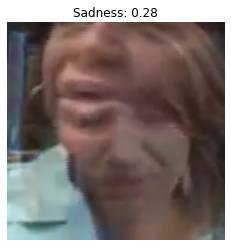

In [ ]:
for img_name, probabs in zip(faces_only, frames_probabs):
    img = Image.open(os.path.join(frames_dir, img_name))
    display.clear_output(wait=True)
    plt.axis('off')
    emotion_ind=np.argmax(probabs)
    title=emotion_ind2label[emotion_ind]+": {:.2f}".format(probabs[emotion_ind])
    plt.title(title)
    plt.imshow(img)
    plt.show()